In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

from keras.models import Sequential
from keras.layers import Flatten, Dense

Deze opdracht gaat over het herkennen van gesproken commando's met deep learning.

We maken gebruik van een subset van de data uit de Tensorflow Speech Recognition Challenge: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

Download de file train.7z en sla de uitgepakte bestanden op in de zelfde map als dit bestand (dan kloppen onderstaande paden).

In [8]:
dir = './tensorflow-speech-recognition-challenge/'
train_dir = os.path.join(dir, 'train/train/audio')
test_dir = os.path.join(dir, 'test/audio')

# Visualiseer de data

Laten we eerst eens naar een enkel bestand kijken waarin het woord 'cat' wordt uitgesproken.

In [9]:
example_filename = os.path.join(train_dir, 'cat/0ab3b47d_nohash_0.wav')

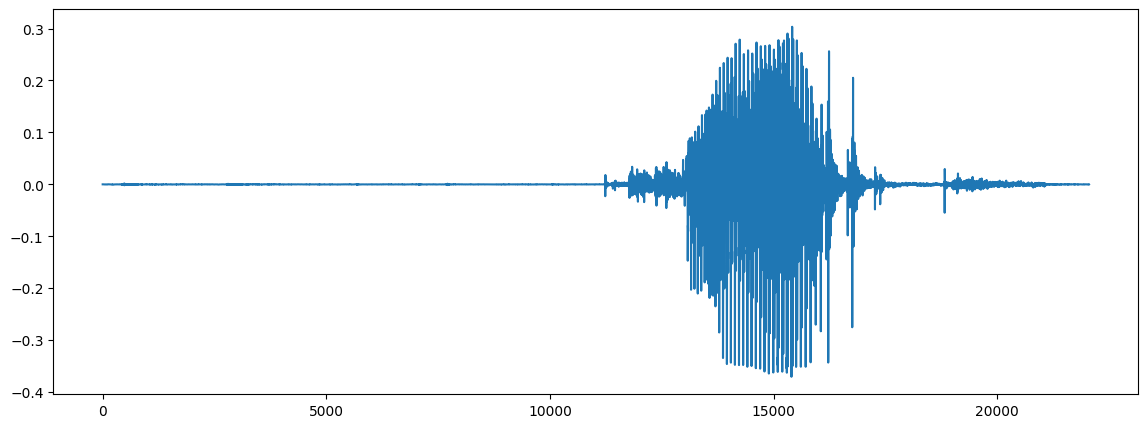

In [10]:
import matplotlib.pyplot as plt

samples_cat, sample_rate = librosa.load(example_filename)

plt.figure(figsize=(14, 5))
plt.plot(samples_cat)
plt.show()


In [11]:
len(samples_cat)

22050

Ter vergelijking bekijken we een opname van het woord 'dog'.

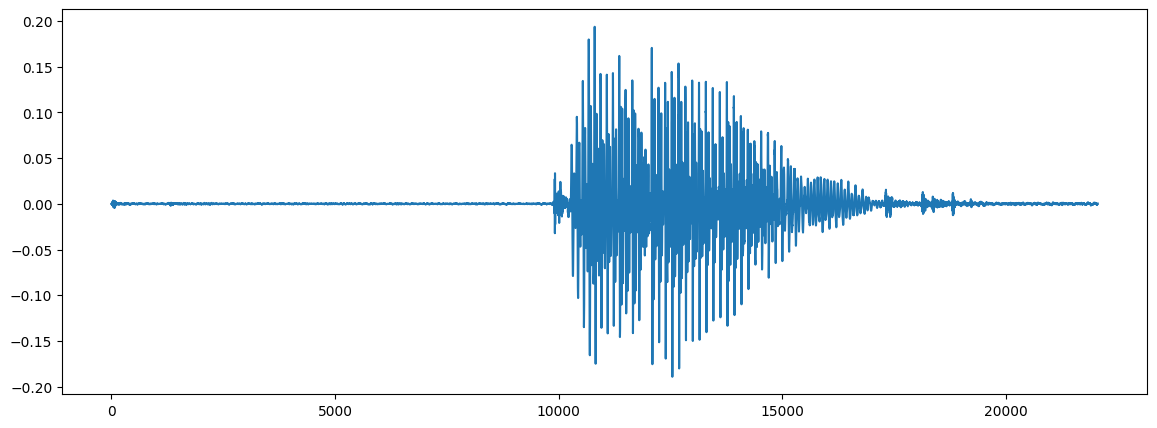

In [12]:
import matplotlib.pyplot as plt

example_filename = os.path.join(train_dir, 'dog/0a7c2a8d_nohash_0.wav')

samples_dog, sample_rate = librosa.load(example_filename)

plt.figure(figsize=(14, 5))
plt.plot(samples_dog)
plt.show()


## Spectrum

We plotten de frequenties in een klein stuk van de opname van 'cat'.

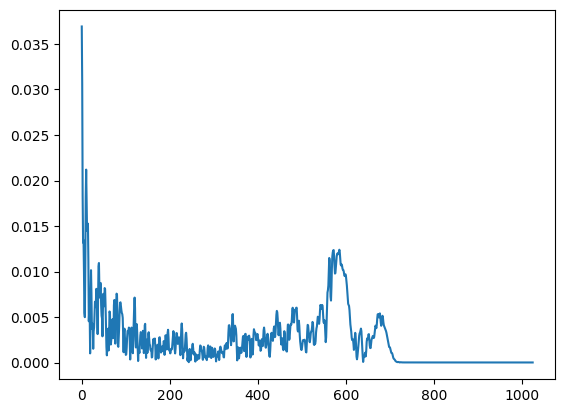

In [13]:
n_fft = 2048
plt.plot(np.abs(librosa.stft(samples_cat[:n_fft], n_fft=n_fft, hop_length = n_fft + 1)))

## Spectogram

Een spectogram laat de geluidsintensiteit op verschillende frequenties uitgezet in de tijd zien.

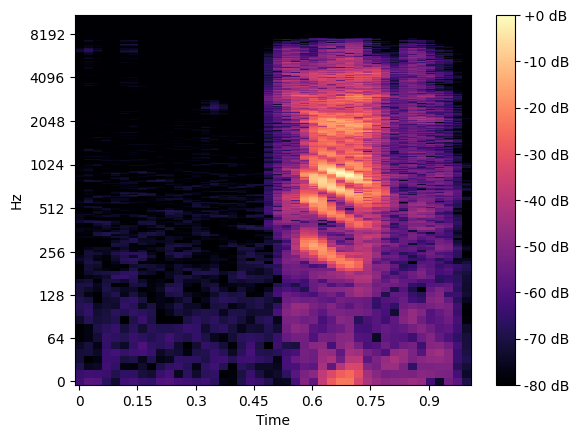

In [14]:
#cat

hop_length = 512

stft = np.abs(librosa.stft(samples_cat, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format='%+2.0f dB')

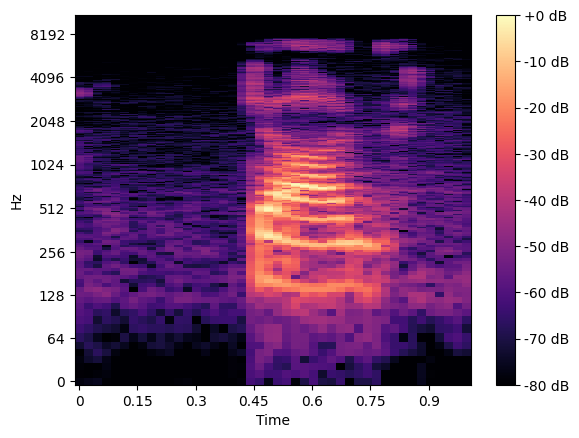

In [15]:
#dog

stft = np.abs(librosa.stft(samples_dog, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format='%+2.0f dB')

## MFCC

MFCC features proberen de belangrijkste informatie in een spraaksignaal te representeren.

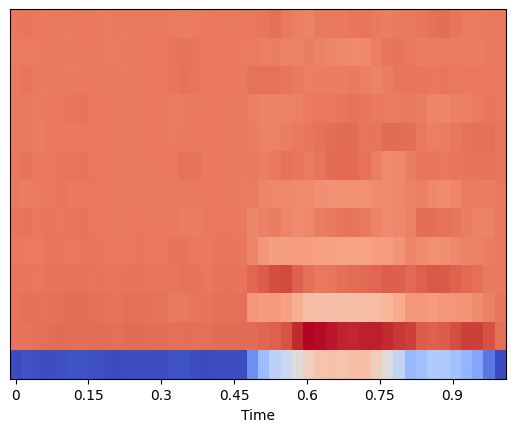

In [16]:
mfccs = librosa.feature.mfcc(y=samples_cat, sr=sample_rate, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis='time')


# Herkennen van woorden

We kunnen de MFCC representatie gebruiken als input voor een deep learning model. We gaan proberen om een aantal verschillend woorden te herkennen met behulp van een LSTM. 

Je kunt eventueel meer labels toevoegen (namen van de mappen in de dataset).

In [17]:
labels = ['cat', 'dog', 'yes', 'no']

## Prepareer de data

We zetten alle opnamen van de betreffende woorden om in MFCC features. We kiezen hier voor 13 MFCC features die we elke 10 ms berekenen voor een stukje van 25 ms van het spraaksignaal.

In [18]:
X_train = []
y_train = []
max_len = 80  # to simplify our model we use a fixed length for the inputs

for label in labels:
    wav_dir = os.path.join(train_dir, label)
    waves = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]
    
    for wav in waves:
        samples, sample_rate = librosa.load(os.path.join(wav_dir, wav), sr = 16000)
        mfccs = librosa.feature.mfcc(y=samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
        
        if (mfccs.shape[1] > max_len):  # truncate recordings that are too long
            mfccs = mfccs[:, :max_len]
        else:  # pad recordings that are too short
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        X_train.append(mfccs)
        y_train.append(label)

We brengen X_train en y_train in de juiste vorm om gebruikt te worden door `keras` modellen.

In [19]:
X_train = np.array(X_train)
X_train = np.swapaxes(X_train, 1, 2)
X_train.shape

(8231, 80, 13)

In [20]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.array(y_train))

y_train = to_categorical(y_train)

y_train[0:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
X_train.shape

(6584, 80, 13)

In [23]:
y_train.shape

(6584, 4)

## Selecteer een model, train, verbeter, evalueer

Experimenteer met geschikte Deep Learning modellen. Welk model werkt het beste?

Tip 1: de input heeft de vorm: `input_shape = (80, 13)`.

Tip 2: Dropout kan helpen.

In [24]:
import numpy as np
num_classes = len(np.unique(y_train))

#### CNN

In [26]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras


model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(80, 13, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(4, activation='softmax'))   # add this layer otherwise shapes dont allign

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], 80, 13, 1)
X_val = X_val.reshape(X_val.shape[0], 80, 13, 1)

# Train the model
history_cnn = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


Epoch 1/10


103/103 [==============================] - 6s 41ms/step - loss: 1.5769 - accuracy: 0.2082 - val_loss: 1.5624 - val_accuracy: 0.2198
Epoch 2/10
103/103 [==============================] - 4s 38ms/step - loss: 1.5842 - accuracy: 0.2082 - val_loss: 1.5586 - val_accuracy: 0.2198
Epoch 3/10
103/103 [==============================] - 4s 41ms/step - loss: 1.5781 - accuracy: 0.2082 - val_loss: 1.5567 - val_accuracy: 0.2198
Epoch 4/10
103/103 [==============================] - 4s 42ms/step - loss: 1.5777 - accuracy: 0.2082 - val_loss: 1.5602 - val_accuracy: 0.2198
Epoch 5/10
103/103 [==============================] - 4s 38ms/step - loss: 1.5797 - accuracy: 0.2082 - val_loss: 1.5637 - val_accuracy: 0.2198
Epoch 6/10
103/103 [==============================] - 4s 41ms/step - loss: 1.5813 - accuracy: 0.2082 - val_loss: 1.5638 - val_accuracy: 0.2198
Epoch 7/10
103/103 [==============================] - 4s 42ms/step - loss: 1.5740 - accuracy: 0.2082 - val_loss: 1.5646 - val_accuracy: 0.21

#### RNN

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_rnn = Sequential()
model_rnn.add(LSTM(128, return_sequences=True, input_shape=(80, 13)))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(128))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(num_classes, activation='softmax'))
model_rnn.add(Dense(4, activation='softmax'))  # add this layer otherwise shapes dont allign


model_rnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Train the RNN model
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


Epoch 1/10
103/103 [==============================] - 36s 279ms/step - loss: 1.3649 - accuracy: 0.3196 - val_loss: 1.3721 - val_accuracy: 0.2823
Epoch 2/10
103/103 [==============================] - 22s 212ms/step - loss: 1.2983 - accuracy: 0.3328 - val_loss: 1.2278 - val_accuracy: 0.3716
Epoch 3/10
103/103 [==============================] - 22s 216ms/step - loss: 1.2302 - accuracy: 0.3764 - val_loss: 1.1964 - val_accuracy: 0.3855
Epoch 4/10
103/103 [==============================] - 20s 197ms/step - loss: 1.1464 - accuracy: 0.5073 - val_loss: 1.1120 - val_accuracy: 0.5155
Epoch 5/10
103/103 [==============================] - 23s 221ms/step - loss: 1.1159 - accuracy: 0.5152 - val_loss: 1.0935 - val_accuracy: 0.5124
Epoch 6/10
103/103 [==============================] - 22s 219ms/step - loss: 1.1277 - accuracy: 0.5049 - val_loss: 1.0932 - val_accuracy: 0.4936
Epoch 7/10
103/103 [==============================] - 25s 240ms/step - loss: 1.0394 - accuracy: 0.5322 - val_loss: 1.0275 - val_ac

#### Dense Neural Network

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model_dnn = Sequential()
model_dnn.add(Flatten(input_shape=(80, 13)))
model_dnn.add(Dense(256, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(256, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(num_classes, activation='softmax'))
model_dnn.add(Dense(4, activation='softmax'))  # add this layer otherwise shapes dont allign

model_dnn.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Train the DNN model
history_dnn = model_dnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


Epoch 1/10
103/103 [==============================] - 3s 13ms/step - loss: 1.4245 - accuracy: 0.2334 - val_loss: 1.4109 - val_accuracy: 0.2878
Epoch 2/10
103/103 [==============================] - 1s 10ms/step - loss: 1.3929 - accuracy: 0.2890 - val_loss: 1.3907 - val_accuracy: 0.2878
Epoch 3/10
103/103 [==============================] - 2s 19ms/step - loss: 1.3804 - accuracy: 0.2892 - val_loss: 1.3820 - val_accuracy: 0.2878
Epoch 4/10
103/103 [==============================] - 1s 14ms/step - loss: 1.3759 - accuracy: 0.2865 - val_loss: 1.3789 - val_accuracy: 0.2878
Epoch 5/10
103/103 [==============================] - 2s 15ms/step - loss: 1.3745 - accuracy: 0.2910 - val_loss: 1.3776 - val_accuracy: 0.2823
Epoch 6/10
103/103 [==============================] - 1s 12ms/step - loss: 1.3741 - accuracy: 0.2798 - val_loss: 1.3770 - val_accuracy: 0.2823
Epoch 7/10
103/103 [==============================] - 1s 9ms/step - loss: 1.3738 - accuracy: 0.2846 - val_loss: 1.3769 - val_accuracy: 0.2823


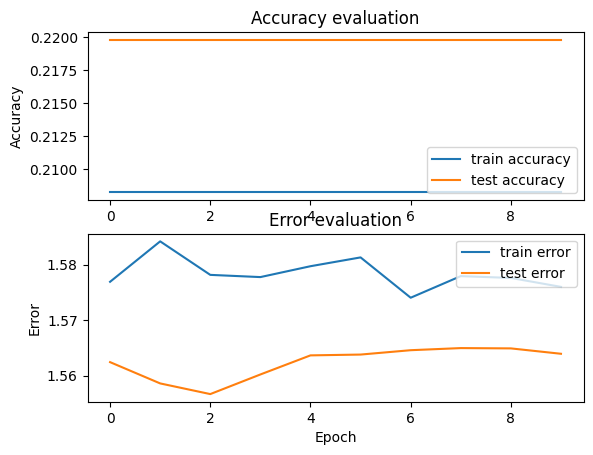

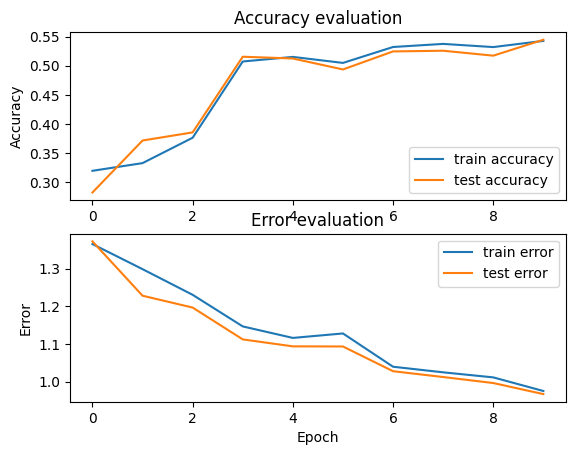

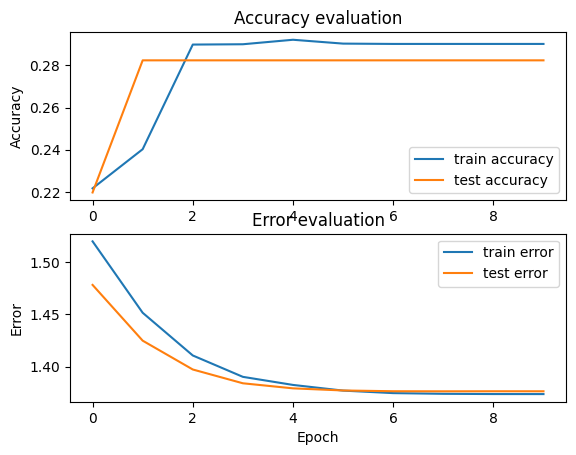

In [33]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error evaluation")

    plt.show()

# Plot history for each model
plot_history(history_cnn)
plot_history(history_rnn)
plot_history(history_dnn)


Zijn er woorden die de modellen vaak door elkaar halen?

The words no, up and down are predicted wrong many times, the model predicted them as the word yes


In [53]:
label_dict = {
    0: 'Yes', 1: 'No', 2: 'Up', 3: 'Down', 4: 'Left', 5: 'Right', 6: 'On', 7: 'Off', 8: 'Stop', 9: 'Go',
    10: 'Zero', 11: 'One', 12: 'Two', 13: 'Three', 14: 'Four', 15: 'Five', 16: 'Six', 17: 'Seven', 18: 'Eight', 19: 'Nine',
    20: 'Bed', 21: 'Bird', 22: 'Cat', 23: 'Dog', 24: 'Happy', 25: 'House', 26: 'Marvin', 27: 'Sheila', 28: 'Tree', 29: 'Wow'
}

# Create a dictionary to store the counts of incorrect predictions
incorrect_predictions = {}

# Now you can use this dictionary to get the labels
for actual, predicted in zip(y_val, model.predict(X_val)):
    actual_label = label_dict[np.argmax(actual)]
    predicted_label = label_dict[np.argmax(predicted)]
    if actual_label != predicted_label:
        if (actual_label, predicted_label) in incorrect_predictions:
            incorrect_predictions[(actual_label, predicted_label)] += 1
        else:
            incorrect_predictions[(actual_label, predicted_label)] = 1

# Print the counts of incorrect predictions
for (actual, predicted), count in incorrect_predictions.items():
    print(f"Actual: {actual}, Predicted: {predicted}, Count: {count}")


52/52 [==============================] - 0s 8ms/step
Actual: No, Predicted: Yes, Count: 346
Actual: Up, Predicted: Yes, Count: 465
Actual: Down, Predicted: Yes, Count: 474


Bonusvraag: Hierboven hebben we plaatjes gemaakt van de data. We zouden deze afbeeldingen als input kunnen beschouwen. We zien iedere input dan dus als een twee-dimensionale afbeelding en kunnen deze classificeren met modellen voor beeldherkenning. Maak zo'n model.

Het is dan wel nodig om de vorm van `X_train` en `X_val` zo aan te passen dat deze een 'kleuren kanaal' hebben. Je kunt dit op de MFCC features doen, maar ook op een spectogram. gebruik hiervoor `librosa.melspectogram`.